In [45]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from diopter.compiler import SourceProgram, Language, CompilerExe, CompilationSetting, OptLevel
from utils import get_ratio, get_binary_size
import seaborn as sns

sns.set_theme(style="ticks")

In [35]:
COMPILER = {
    "gcc": CompilerExe.get_system_gcc(),
    "clang": CompilerExe.get_system_clang(),
}

def load_settings(settings_path):
    experiment_settings = {}
    with open(settings_path, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("Experiment settings:"):
                continue
            if line:
                key, value = line.split(": ", 1)
                experiment_settings[key] = value


    return experiment_settings

def get_ratios(experiment_dir):
    experiment_settings_path = os.path.join(experiment_dir, "settings.log")
    experiment_settings = load_settings(experiment_settings_path)
    compilation_setting = CompilationSetting(
        compiler=COMPILER[experiment_settings["compiler"]],
        opt_level=OptLevel.from_str(experiment_settings["opt_level"]),
        flags=("-march=native",),
    )

    name = f'{experiment_settings["compiler"]} -{experiment_settings["opt_level"]}, timeout: {experiment_settings["timeout"]}s'
    ratios = []

    for iteration_dir in os.listdir(experiment_dir):
        iteration_path = Path(experiment_dir) / iteration_dir
        if iteration_path.is_dir():
            step = int(iteration_dir.split("_")[1])
            c_program_path = iteration_path / "best.c"
            if c_program_path.exists():
                with open(c_program_path, "r") as f:
                    code = f.read()
                p = SourceProgram(
                    code=code,
                    language=Language.C,
                )
                ratios.append((step,get_ratio(p, compilation_setting)))
    return name, sorted(ratios)

In [63]:
main_program = SourceProgram(code="int main() {}", language=Language.C)
setting = CompilationSetting(compiler=CompilerExe.get_system_clang(),
        opt_level=OptLevel.O3,
        flags=("-march=native",),)
main_ratio = get_ratio(main_program, setting)

print(f"binary size: {get_binary_size(main_program, setting)}, ratio: {main_ratio}")

binary size: 51, ratio: 3.923076923076923


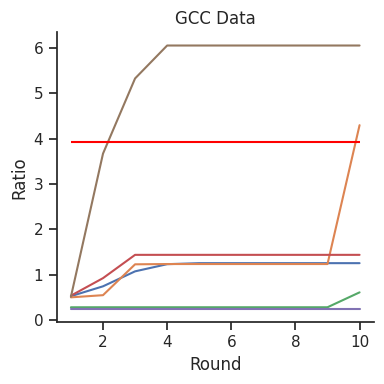

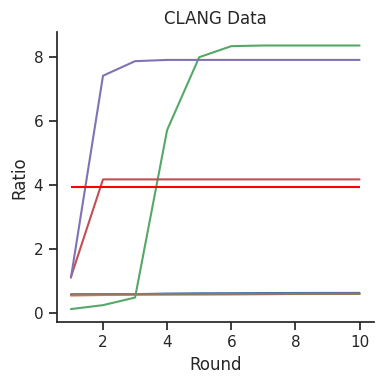

In [68]:

# Set the Seaborn theme
sns.set_theme(style="ticks")

experiment_root = "/home/remo/Documents/eth/fs23/ast2023/out_new"

# Create separate plots for "gcc" and "clang"
for name_prefix in ["gcc", "clang"]:
    plt.figure(figsize=(4, 4))  # Set figure size for each plot

    for experiment_dir in os.listdir(experiment_root):
        experiment_dir = os.path.join(experiment_root, experiment_dir)
        name, ratios = get_ratios(experiment_dir)
        if name.startswith(name_prefix):
            x, y = zip(*ratios)
            sns.lineplot(x=x, y=y, label=name, legend=False)

    plt.hlines(main_ratio, 1, 10, colors="red")
    plt.xlabel("Round")
    plt.ylabel("Ratio")
    plt.title(f"{name_prefix.upper()} Data")
    plt.tight_layout()
    sns.despine()
    plt.show()